In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import sin, cos
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
def one_hot_target(target_val):
  one_hotted = np.zeros(8)
  target_val = int(target_val)
  if target_val < 1:
    one_hotted[target_val+4] = 1
  else:
    one_hotted[target_val+3] = 1
  return one_hotted

In [ ]:
data = pd.read_csv("/content/drive/My Drive/CS449_Project/CS_449_Data/full_dataset_4.csv")
data = data[['ticker','return', 'Volume', 'op_income_pre_dep', 'op_income_post_dep', 'sales_net', 'current_assets', 'current_liabilities', 'retained_earnings', 'working_capital','return group']].dropna()
print(data["return group"].unique())
# for i in data["return group"].unique():
#   print(one_hot_target(i))
print(data)

num_data_points = 3

need_multiple = num_data_points*data.shape[1]
# print(need_multiple)
trainX = []
trainY = []
for i in range(num_data_points):        #get data point groups, increment to ensure all combinations included
  seq_data = data[i:data.shape[0]]
  # print(seq_data.shape)
  seq_data = seq_data[0:seq_data.shape[0]-(seq_data.shape[0]%need_multiple)]
  seq_data = np.array(seq_data)
  seq_data = np.reshape(seq_data, (-1, num_data_points, data.shape[1]))
  # print(seq_data.shape)
  # print(seq_data)
  # print("__________________")
  filter_for_ticker_overlap = []
  for i in seq_data:
    if i[0][0] == i[1][0]:
      filter_for_ticker_overlap.append(True)
    else:
      filter_for_ticker_overlap.append(False)
  # print(seq_data.shape)
  seq_data = seq_data[filter_for_ticker_overlap]
  # print(seq_data.shape)
  train_filter = [False,True,True,True,True,True,True, True, True, True, False]
  # train_filter = [False,True,False,False,False,False, False, False, False, False, False, False]
  for data_point_set in seq_data:
    new_X_val = []
    for j in range(num_data_points):
      new_X_val.append(data_point_set[j][train_filter])
    trainX.append(new_X_val)
    trainY.append(one_hot_target(data_point_set[num_data_points-1][10]))

trainX = np.array(trainX)
trainX = trainX.astype(float)
trainY = np.array(trainY)
trainY = trainY.astype(float)

x, x_test, y, y_test = train_test_split(trainX, trainY, test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, shuffle=True)
# print(trainY[0:5])
# print(trainX[0])

[ 4. -4. -1.  1.  3.  2. -3. -2.]
      ticker     return      Volume  op_income_pre_dep  op_income_post_dep  \
1        AAL  90.385527  -31.306631         310.714286               402.0   
2        AAL  26.349981   32.701002         313.913043               767.0   
3        AAL -70.894338   -5.591655        -109.453782               265.0   
4        AAL -39.428968   18.326575         315.555556               122.0   
5        AAL -71.941634  112.586071         -32.620321               198.0   
...      ...        ...         ...                ...                 ...   
38405   ALLE  11.179367  -14.015854          10.967251               166.2   
38406   ALLE  -4.865881   79.737152          -2.402196               162.3   
38407   ALLE   0.471516  -69.398669         -18.846695               136.5   
38408   ALLE -16.804949  190.335235           5.979203               142.7   
38409   ALLE -10.459127    3.869304          24.284546               171.7   

       sales_net  current_ass

In [ ]:
from tensorflow.keras import backend as K

risk_factor = 0.5

def custom_BCE(y_true, y_pred, weight_factor = 1.0):
  epsilon = K.epsilon()
  y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
  loss = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0-y_pred))
  false_negatives = tf.logical_and(tf.equal(y_true, 1), tf.less(y_pred, risk_factor))
  false_negatives_loss = loss * weight_factor
  loss = tf.where(false_negatives, false_negatives_loss, loss)
  return K.mean(loss)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Define the MLP model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(num_data_points, trainX.shape[2])),
    layers.Dropout(0.2),  # Adding dropout regularization
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout regularization
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')  # Assuming there are 4 classes (large gain, small gain, small loss, big loss)
])



learning_rate = 0.001  # Define your desired learning rate

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, verbose=2, batch_size=128, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
# Print training progress every 10 epochs
# for epoch in range(10, 51, 10):
#     print(f"Epoch {epoch}/{50} - loss: {history.history['loss'][epoch-1]} - accuracy: {history.history['accuracy'][epoch-1]} - val_loss: {history.history['val_loss'][epoch-1]} - val_accuracy: {history.history['val_accuracy'][epoch-1]}")


Epoch 1/20
181/181 - 2s - loss: 59.4980 - accuracy: 0.1233 - val_loss: 6.6971 - val_accuracy: 0.1140 - 2s/epoch - 13ms/step
Epoch 2/20
181/181 - 1s - loss: 24.9789 - accuracy: 0.1479 - val_loss: 5.3206 - val_accuracy: 0.1503 - 1s/epoch - 7ms/step
Epoch 3/20
181/181 - 1s - loss: 14.5394 - accuracy: 0.1569 - val_loss: 3.6120 - val_accuracy: 0.1585 - 1s/epoch - 7ms/step
Epoch 4/20
181/181 - 1s - loss: 11.0640 - accuracy: 0.1567 - val_loss: 3.4725 - val_accuracy: 0.1546 - 927ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 9.4059 - accuracy: 0.1540 - val_loss: 3.8659 - val_accuracy: 0.1554 - 729ms/epoch - 4ms/step
Epoch 6/20
181/181 - 1s - loss: 18.3218 - accuracy: 0.1565 - val_loss: 3.2195 - val_accuracy: 0.1593 - 749ms/epoch - 4ms/step
Epoch 7/20
181/181 - 1s - loss: 7.6259 - accuracy: 0.1546 - val_loss: 2.8801 - val_accuracy: 0.1546 - 781ms/epoch - 4ms/step
Epoch 8/20
181/181 - 1s - loss: 4.6841 - accuracy: 0.1557 - val_loss: 2.6518 - val_accuracy: 0.1617 - 763ms/epoch - 4ms/step
Epo

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

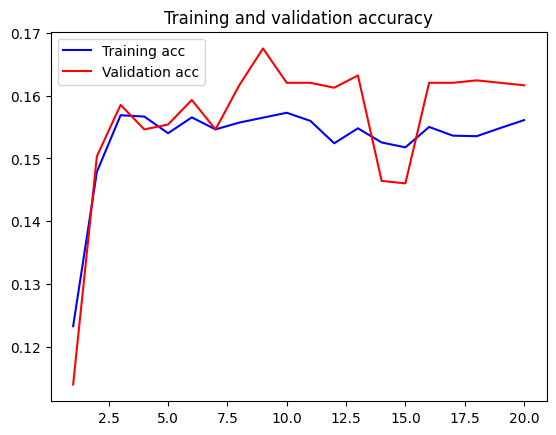

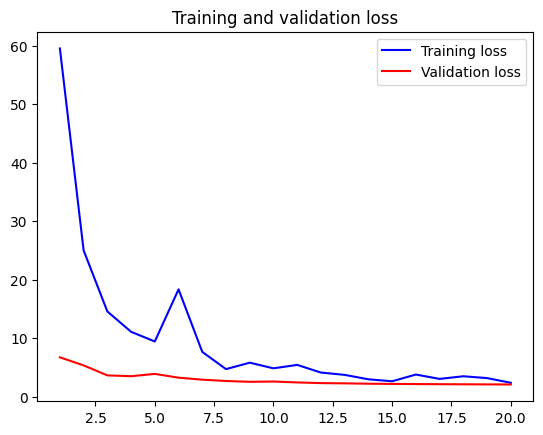

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()